In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pickle

sns.set_style('white')
%matplotlib inline

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.weight'] = 'bold'

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Load in processed data

In [2]:
df_rel_sort_list = pickle.load(open('pickle_files/rel_sort_lod_list.pkl', 'rb'))
df_abs_sort_list = pickle.load(open('pickle_files/abs_sort_lod_list.pkl', 'rb'))

df_pseudo_rel_sort_list = pickle.load(open('pickle_files/pseudo_rel_sort_lod_list.pkl', 'rb'))
df_pseudo_abs_sort_list = pickle.load(open('pickle_files/pseudo_abs_sort_lod_list.pkl', 'rb'))

df_col_names_list = pickle.load(open('pickle_files/col_names_lod_list.pkl', 'rb'))
df_metadata = pickle.load(open('pickle_files/metadata_comp.pkl', 'rb'))

### Generate list of genera that are >1% in any sample

In [3]:
# Determine which taxa are present in samples above 1% abundance
col_list = []

for col in df_rel_sort_list[4].columns:
    _obj = df_rel_sort_list[4].apply(lambda x: True if x[col]>1 else False, axis=1)
    if len(_obj[_obj==True].index) > 0:
        col_list.append(col)

print(len(col_list))

110


### Load in aerobicity lookup file
Please note that any microbes capable of aerobic respiration are referred to as aerobes in this file. Strict anaerobes are referred to as anaerobes.

In [4]:
df_aerobe = pd.read_csv('data_files/aerobicity_lookup_file.csv')
aerobe_dict = {df_aerobe['label'].iloc[i] : df_aerobe['aerobicity'].iloc[i] for i in range(len(df_aerobe))}

### Filter samples by the columns present at 1% or above

In [5]:
df_rel_filtered = df_rel_sort_list[4][col_list]
df_abs_filtered = df_abs_sort_list[4][col_list]

df_pseudo_rel_filtered = df_pseudo_rel_sort_list[4][col_list]
df_pseudo_abs_filtered = df_pseudo_abs_sort_list[4][col_list]

### Group taxa by aerobe/anaerobe label

In [6]:
labels = pd.DataFrame(df_abs_filtered.columns).merge(df_col_names_list[4], left_on=0, right_index=True)['label'].tolist()
aerobicity_columns = []

for val in labels:
    if val in aerobe_dict.keys():
        aerobicity_columns.append(aerobe_dict[val])
    else:
        print('Missing: ' + val)
        aerobicity_columns.append('Missing')
        
df_abs_filtered.columns = aerobicity_columns

In [7]:
df_grouped = df_abs_filtered.T.reset_index().groupby('index').sum().T[['aerobic', 'anaerobic']]
df_grouped_melt = pd.melt(df_grouped, var_name='aerobicity', value_name='Copies/mL')

### Calculate the aerobic and anaerobic percentage in each sample

In [8]:
df_grouped = df_grouped.merge(pd.DataFrame(df_abs_sort_list[4].sum(axis=1)).rename(columns={0:'Total Load'}), left_index=True, right_index=True)
df_grouped['aerobic_percent'] = df_grouped['aerobic']/df_grouped['Total Load']*100
df_grouped['anaerobic_percent'] = df_grouped['anaerobic']/df_grouped['Total Load']*100

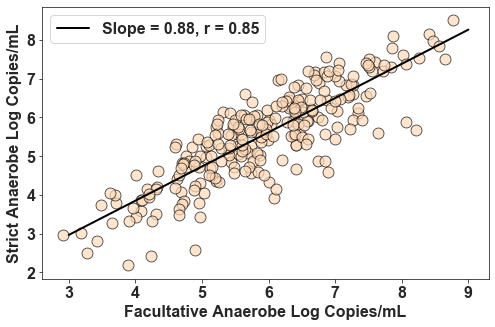

In [9]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

sns.scatterplot(ax=ax1, x=np.log10(df_grouped['aerobic']+1), y=np.log10(df_grouped['anaerobic']+1), s=120, 
                alpha=0.7, color='peachpuff', edgecolor='k')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df_grouped['aerobic']+1), np.log10(df_grouped['anaerobic']+1))

xx = np.linspace(3,9,50)
yy = xx*slope+intercept

ax1.plot(xx, yy, label='Slope = '+str(round(slope,2))+ ', r = ' + str(round(r_value,2)), linewidth=2, color='k', ls='-')

ax1.set_ylabel('Strict Anaerobe Log Copies/mL', fontsize=16, fontweight='bold')
ax1.set_xlabel('Facultative Anaerobe Log Copies/mL', fontsize=16, fontweight='bold')
ax1.legend(fontsize=16)
#fig.savefig('aerobe_v_anaerobe.png', bbox_inches='tight', dpi=200)
#fig.savefig('aerobe_v_anaerobe.pdf', bbox_inches='tight', transparent=True)

In [10]:
metadata_aerobicity = df_metadata.merge(df_grouped[['aerobic', 'anaerobic', 'aerobic_percent', 'anaerobic_percent']], left_index=True, right_index=True)

In [11]:
metadata_aerobicity.to_pickle('pickle_files/metadata_comp_aerobicity.pkl')